<a href="https://colab.research.google.com/github/ashutoshsinha25/tensorflow-developement/blob/main/Milestone%20Project/07_Food_Vision_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Food Vision Project (food101)

## GPU 
* Google Colab offers free GPU, however not all f them are compatiable with the mixed precision training.

Google Colab offers :- 
* K80 (not compatiable)
* P100 (not compatiable)
* Tesla T4 (compatiable)

Knowing this , in order to use mixed precision training we need access to Tesla T4 ( from within colab) or if we're using our own hardware, our GPU needs a score of 7.0+ 

In [ ]:
# we want to use mixed precision function of tensorflow which are available for hardware how's Compute Capability is 7.0 or above. 

In [ ]:
!nvidia-smi

Wed Apr 13 11:02:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d32ec307-8672-4524-1edf-9d3ec6f2f09e)


## Get helper functions

we use bunch of helper functions to do small tasks required. Rather than rewriting all of these, we can import a script and load them in from there.

The scripts we've got available can be found on github

In [ ]:
# download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-13 11:07:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-13 11:07:53 (96.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Impoer series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback , plot_loss_curves , compare_historys

## Use tensorflow datastes to download data ( TFDS)

In [ ]:
# Get tensorflow datasets 
import tensorflow_datasets as tfds

In [ ]:
# list all of the available datset 
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# load/download data which are already in tensor format i.e ready to build model format
# if we pass a huge dataset to download it (for local use),
# ds_info ---> meta data 
# tdfs datasets are static datasets
(train_data , test_data) , ds_info = tfds.load(name = 'food101',
                                               split = ['train' , 'validation'],
                                               shuffle_files = True,
                                               as_supervised = True,  # data gets returned as tuple (data , label)
                                               with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete0546A1/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete0546A1/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

we want ot find:- 
* class names
* the shape of our input data (image tensors)
* datatype of out input data
* what labels look like?  (e.g. are they one-hot encoded or label encoded)
* do labels match up with the class names?

In [ ]:
# features of food1010 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# get the class name 
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# taking one sample if the train data
# grab training data and take one of them ---> train_data.take(1)
train_one_sample = train_data.take(1) # samples are in format (image_tensorf,  label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
len(train_one_sample)

1

In [ ]:
# output info about our training sample
for image , label in train_one_sample:
  print(f"""
    Image shape : {image.shape}
    Image datatype : {image.dtype}
    Target class from Food101 : {label}
    Class name (str form) : {class_names[label.numpy()]}
    """)


    Image shape : (512, 512, 3)
    Image datatype : <dtype: 'uint8'>
    Target class from Food101 : 16
    Class name (str form) : cheesecake
    


In [ ]:
# our image tensorf from tdfs look like?
# we see above that all the images are not of same size 
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
# min and max values of image tensors
# neural networks like there image input values to be between 0 and 1
import tensorflow as tf
tf.reduce_min(image) , tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

(-0.5, 511.5, 511.5, -0.5)

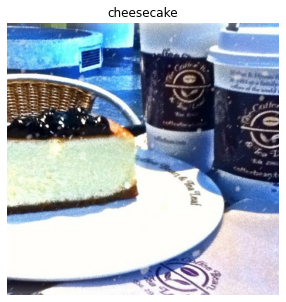

In [ ]:
# plot an image tensor
import matplotlib.pyplot as plt 

plt.figure(figsize = (5,5))
plt.imshow(image)
plt.title(class_names[label.numpy()]) # we want to make sure / verify that the labels is associated with the right image 
plt.axis(False)

## Create preprocessing functions for our data 

Neural Networks perform best when data is in a certain way e.g. batched , normalized , etc. However, not all data comes like this.
So in order to get it ready for a neural network, we often have to write preprocessing functions and map it to your data.
 
What we know about our data:
* its in `uint8` datatype
* comprised of all different size of tensors (different sized images)
* not scaled (the pixel values are between 0 and 255)

What we know models like:
* data in `float32` dtype (or for mixed precision `float16` and `float32` )
* for batches, tensoflow likes all of the tensors within a batch to be of the same size
* scaled( values between 0 and 1) also called normalized tensors, generally perform better.


we're going to be using EfficientNetBX pretrained model from tf.keras.applications we dont need to rescale our data ( this architecture have rescalling built-in).


thus our functions need to:-
1. reshape our images to all the same size
2. convert the dtype of our image tensors from `unit8` tp `float32`

In [ ]:
# defining the functions for preprocessing the images

def preprocess_img(image , label , img_shape= 224):
  """
  Convert image datatype from 'unit8' --> 'float32 and reshapes
  image to  [img_shape , img_shape , color_channels]
  """
  image = tf.image.resize(image , size = [img_shape , img_shape]) # reshape target img
  # image = image/255. # scaled image --> not required with efficientnetbx models
  return tf.cast(image , tf.float32) , label


In [ ]:
# preprocess a single sample image and check the output
preprocessed_img = preprocess_img(image , label)[0]
print(f"image before preprocessing:\n {image[:2]}..., \n shape: {image.shape} , \ndatatype: {image.dtype}")
print(f'image after preprocessing:\n {preprocessed_img[:2]}..., \n shape: {preprocessed_img.shape} , \ndatatype: {preprocessed_img.dtype}')

image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
 shape: (512, 512, 3) , 
datatype: <dtype: 'uint8'>
image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
 shape: (224, 224, 3) , 
datatype: <dtype: 'float32'>


## Batch and prepair dataset

`imp feature of tensorflow :- data input piipeline` [link text](https://www.tensorflow.org/guide/data_performance)

this pipeline makes our data input pipeline run really fast .

In [ ]:
train_data

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# map preprocessing function to training data (and parallelize it)
# num_parallel_calls ---> utilize all the compute core available to use.
# we are bascially replicating what was in the image_dataset_fromm_director function
train_data = train_data.map(map_func = preprocess_img , num_parallel_calls = tf.data.AUTOTUNE)


# shuffle train_data and turn it into batches and prefetch it (load it faster)
# buffere_size --> how many element to shuffle at a single time (ideally it would be something like len(train_data), every data in the training set)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# similar process for the testing data 

test_data = test_data.map(map_func = preprocess_img , num_parallel_calls= tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data , test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

above code in simpler english:

>"tensorflow, map the preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batch (`prefetch`) whist the model is looking through (finding patterns) the current batch""

## Create modelling callbacks

* tensorbaord callbak
* modelcheckpoint callback : to save our models progress after feature extraction

In [ ]:
# create tesorboard callback (import from helper func)
from helper_functions import create_tensorboard_callback

# create model checkpoint call back , we are saving the weights only
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       moniotr = 'val_acc',
                                                       save_best_only = True,
                                                       save_weight_only = True,
                                                       verbose = 0)

## Setup mixed precision training

mixed precision utilized a combination of float16 and float32 datatype to speed up the model performance

In [ ]:
# tuen n mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
!nvidia-smi

Wed Apr 13 12:59:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |    278MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extractio model 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

In [ ]:
# create a base model 
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


# create functional model 
inputs = layers.Input(shape = input_shape , name = 'input_layer')

# note: EfficientNetBX models have rescalling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescalling(1. / 255)(x)

x = base_model(inputs , training = False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation('softmax' , dtype = tf.float32 , name = 'softmax_float32')(x)
model = tf.keras.Model(inputs , outputs)


# compile the model 
model.compile(loss = 'sparse_categorical_crossentropy' ,
               optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model.layers:
  print(layer.dtype)

float32
float32
float32
float32
float32


## Checking layers dtype policy 

In [ ]:
# check the dtype policy attributes of layers in our model 
for layer in model.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


we see from above code:
* `layer.name` : human readable name of the layer
* `layer.trainable` : is the layer trainable or not?
* `layer.dtype` : datatype a layers stores its variables in 
* `layer.stype_policy` : datatype policy a layer computes on its variables with  

In [ ]:
# check the above parameters for the EfficientNetB0 model 
for layer in model.layers[1].layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Fit the feature extraction model 

If out goal is to fine-tune a pretrained mmodel , the general order of doing things is:
1. build a feature extraction model ( train a couple output layers with the base layers frozen)
2. fine-tune some of the frozen layers

In [ ]:
# fit the feature extraction model with callbacks

history_101_food_classes_feature_extract = model.fit(train_data ,
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * (len(test_data))),
                                                     callbacks = [create_tensorboard_callback(dir_name = 'training_logs',
                                                                                               experiment_name = 'efficientnetb0_101_classes_all_data_feature_extract'),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220413-133358
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.5575INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


2368/2368 [==============================] - 247s 96ms/step - loss: 1.8224 - accuracy: 0.5575 - val_loss: 1.2191 - val_accuracy: 0.6745
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.6672INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


2368/2368 [==============================] - 214s 90ms/step - loss: 1.2927 - accuracy: 0.6672 - val_loss: 1.1231 - val_accuracy: 0.6989
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1440 - accuracy: 0.7023INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


2368/2368 [==============================] - 214s 89ms/step - loss: 1.1440 - accuracy: 0.7023 - val_loss: 1.0845 - val_accuracy: 0.7066


In [ ]:
# evaluate model on whole test dataset 
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 65ms/step - loss: 1.0861 - accuracy: 0.7060


[1.0861114263534546, 0.7060198187828064]

## Peapare our model's layer for fine-tuning

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-04-13 13:51:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2022-04-13 13:51:21 (136 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# load and evaluate downloaded GS model 
tf.get_logger().setLevel('INFO') # hide warning logs
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")


In [ ]:
# get the model summary 
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# eavaluating the loaded model 
result_loaded_gs_model = loaded_gs_model.evaluate(test_data)
result_loaded_gs_model

790/790 [==============================] - 68s 82ms/step - loss: 1.0881 - accuracy: 0.7065


[1.088128685951233, 0.7064950466156006]

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in loaded_gs_model.layers:
  layer.trainable = True # setiing all the layers as trainable 
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# cheking dtype_policies in efficient net model of loaded_gs_model
for layer in loaded_gs_model.layers[1].layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

## Setting up callbacks as we did with features extraction model 


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 3)
checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path ,
                                                      save_best_only = True,
                                                      monitor = 'val_loss')

In [ ]:
# compile the model 

loaded_gs_model.compile(loss = 'sparse_categorical_crossentropy' ,
                        optimizer = tf.keras.optimizers.Adam(0.0001),
                        metrics = ['accuracy'])

In [ ]:
# fittinh the fine-tune model 

history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                                  epochs = 100,
                                                                  steps_per_epoch = len(train_data),
                                                                  validation_data = test_data,
                                                                  validation_steps = int(0.15*len(test_data)) ,
                                                                  callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), 
                                                                                  model_checkpoint,
                                                                                    early_stopping])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220413-141401
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.8417INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 391s 159ms/step - loss: 0.5689 - accuracy: 0.8417 - val_loss: 0.7885 - val_accuracy: 0.7794
Epoch 2/100
2368/2368 [==============================] - 339s 142ms/step - loss: 0.3167 - accuracy: 0.9099 - val_loss: 0.8918 - val_accuracy: 0.7805
Epoch 3/100
2368/2368 [==============================] - 337s 142ms/step - loss: 0.1679 - accuracy: 0.9507 - val_loss: 1.0133 - val_accuracy: 0.7720
Epoch 4/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.1045 - accuracy: 0.9685 - val_loss: 1.0492 - val_accuracy: 0.7844


In [ ]:
# evaluating the model 
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 1.0767 - accuracy: 0.7771


[1.0767403841018677, 0.777108907699585]

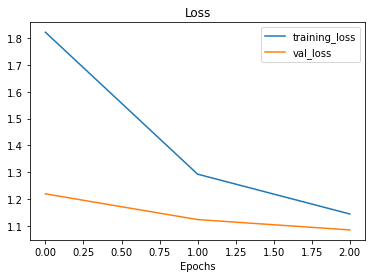

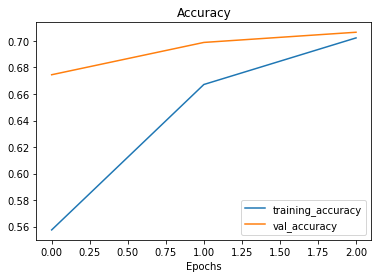

In [ ]:
# plotting the loss curve feature model 

plot_loss_curves(history_101_food_classes_feature_extract)


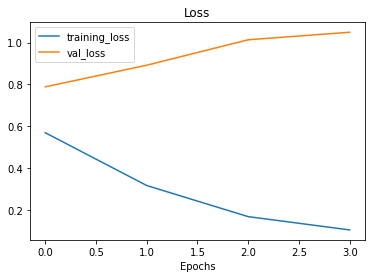

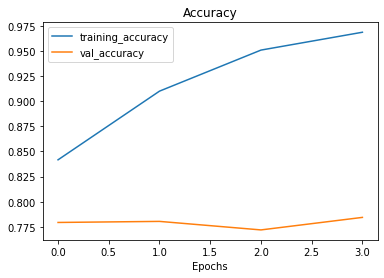

In [ ]:
# plotting the loss curve fine-tune model 
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [ ]:
# checking both evaluation 
print(model.evaluate(test_data))
print("---------------------------")
print(loaded_gs_model.evaluate(test_data))

790/790 [==============================] - 52s 65ms/step - loss: 1.0861 - accuracy: 0.7060
[1.0861119031906128, 0.7060198187828064]
---------------------------
790/790 [==============================] - 49s 62ms/step - loss: 1.0767 - accuracy: 0.7771
[1.0767406225204468, 0.777108907699585]
